In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import sys
import tqdm
import pathlib
from pathlib import Path
import io
import contextlib
import gaps_online as go
import go_pybindings as gop
import re
from glob import glob
import os

Can't load CXX API! No module named 'gaps_tof'


In [235]:
plt.style.use('publication.rc')

In [3]:
dataset = pathlib.Path(f'/Users/gracetytus/gaps/waveforms')
files = [f for f in sorted(dataset.glob('*.tof.gaps'))]

In [4]:
paddle_map = {}
with open(f'/Users/gracetytus/gaps/channel_mapping.csv') as in_file:
    variables = next(in_file).strip().split(',')
    next(in_file)
    for line in in_file:
        row = line.strip().split(',')
        paddle_id = int(row[0])
        paddle_map[paddle_id] = {'a':{'rb':0,'ch':0},'b':{'rb':0,'ch':0}}
        rb, ch = [int(d) for d in row[9].split('-')]
        paddle_map[paddle_id]['a']['rb'] = rb
        paddle_map[paddle_id]['a']['ch'] = ch - 1

        row = next(in_file).strip().split(',')
        rb, ch = [int(d) for d in row[9].split('-')]
        paddle_map[paddle_id]['b']['rb'] = rb
        paddle_map[paddle_id]['b']['ch'] = ch - 1

In [5]:
pattern = re.compile(r'RB(\d+)_\d{6}_\d{6}UTC\.cali\.tof\.gaps')
calibrations = glob('/Users/gracetytus/gaps/waveforms/calibrations/240808_220952UTC/*.cali.tof.gaps')

calib = {}

for fname in calibrations:
    match = pattern.search(fname)
    if match:
        rbid = match.group(1)
        cali = gop.events.RBCalibration()
        cali.from_file(fname)  # Modify the instance
        calib[int(rbid)] = cali      # Store the modified instance
    else:
        print("No match found for:", fname)

print(calib)

{30: <builtins.RBCalibration object at 0x7fa8864d5000>, 28: <builtins.RBCalibration object at 0x7fa88651b000>, 1: <builtins.RBCalibration object at 0x7fa86cf00000>, 35: <builtins.RBCalibration object at 0x7fa86cf25000>, 27: <builtins.RBCalibration object at 0x7fa86cf4a000>, 33: <builtins.RBCalibration object at 0x7fa86cf6f000>, 42: <builtins.RBCalibration object at 0x7fa86cf94000>, 6: <builtins.RBCalibration object at 0x7fa86cfb9000>, 36: <builtins.RBCalibration object at 0x7fa870cf7000>, 32: <builtins.RBCalibration object at 0x7fa870d1c000>, 3: <builtins.RBCalibration object at 0x7fa870d41000>, 20: <builtins.RBCalibration object at 0x7fa870d66000>, 7: <builtins.RBCalibration object at 0x7fa870d8b000>, 44: <builtins.RBCalibration object at 0x7fa870db0000>, 13: <builtins.RBCalibration object at 0x7fa870dd5000>, 17: <builtins.RBCalibration object at 0x7fa870dfa000>, 14: <builtins.RBCalibration object at 0x7fa870e1f000>, 25: <builtins.RBCalibration object at 0x7fa870e44000>, 2: <builtins.

In [6]:
waveform_a         = []
waveform_b         = []
time_a             = []
time_b             = []
q_a                = []
q_b                = []
v_a                = []
v_b                = []

with contextlib.redirect_stderr(io.StringIO()):
    #for f in tqdm.tqdm(files, desc="Processing files", unit="file", file=sys.stdout):
    for f in files:
        reader = go.rust_api.io.TofPacketReader(str(f), filter=go.rust_api.io.PacketType.TofEvent)
        settings = go.liftof.LiftofSettings()
        settings = settings.from_file('/Users/gracetytus/gaps/waveforms/run134.toml')

        n_packets = 0
        for pack in reader:
            n_packets += 1

        reader.rewind()
    
        for pack in tqdm.tqdm(reader, total=n_packets, file=sys.stdout, position=0):
            ev = go.rust_api.events.TofEvent()
            new_ev = go.liftof.waveform_analysis(ev, settings)

            try:
                ev.from_tofpacket(pack)
                
            except Exception as e:
                print(f"Error at hit {x}: {e}")
                pass
                continue

            for x in range(len(new_ev.hits)):
                try: 
                    paddle = int(new_ev.hits[x].paddle_id)

                    if new_ev.hits[x].charge_a == 0 or new_ev.hits[x].charge_b == 0:
                        continue

                    q = new_ev.hits[x].charge_a
                    v = new_ev.hits[x].peak_a
                    t = new_ev.hits[x].time_a

                    rb = paddle_map[paddle]['a']['rb']
                    ch = paddle_map[paddle]['a']['ch']
                    if ch == 8: continue
                    for waveform in new_ev.waveforms:
                        if waveform.rb_id == rb and waveform.rb_channel == ch:
                            waveform.calibrate(calib[rb])
                            waveform.apply_spike_filter()
                            waveform_a.append(waveform.voltages)
                            time_a.append(t)
                            q_a.append(q)
                            v_a.append(v)
                            break
                    
                    q = new_ev.hits[x].charge_b
                    v = new_ev.hits[x].peak_b
                    t = new_ev.hits[x].time_b
                    
                    rb = paddle_map[paddle]['b']['rb']
                    ch = paddle_map[paddle]['b']['ch']
                    if ch == 8: continue
                    for waveform in new_ev.waveforms:
                        if waveform.rb_id == rb and waveform.rb_channel == ch:
                            waveform.calibrate(calib[rb])
                            waveform.apply_spike_filter()
                            waveform_b.append(waveform.voltages)
                            time_b.append(t)
                            q_b.append(q)
                            v_b.append(v)
                            break
                except Exception as e:
                    print(f"Error at hit {x}: {e}")
                    continue
                    
waveform_a = np.array(waveform_a)
waveform_b = np.array(waveform_b)
time_a = np.array(time_a)
time_b = np.array(time_b)
q_a = np.array(q_a)
q_b = np.array(q_b)
v_a = np.array(v_a)
v_b = np.array(v_b)

100%|████████████████████████████████████| 21203/21203 [02:36<00:00, 135.73it/s]


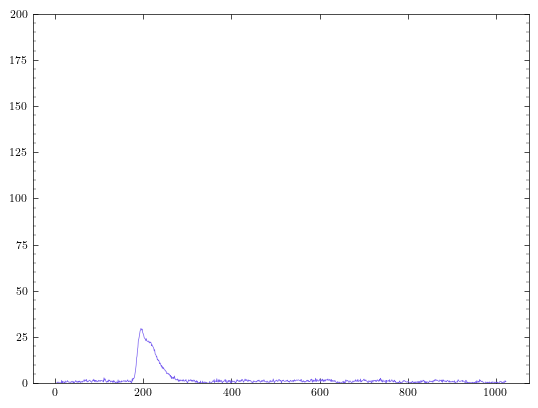

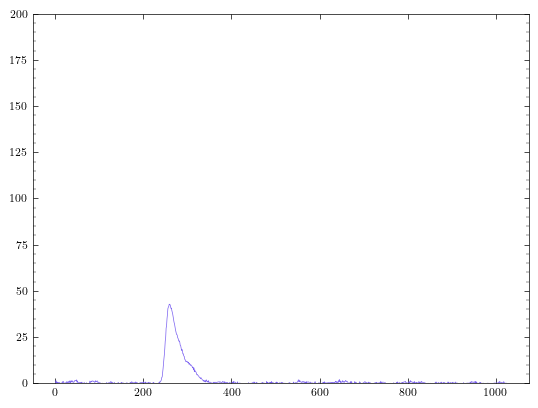

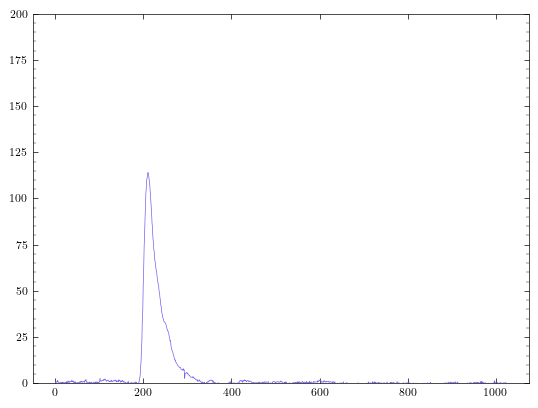

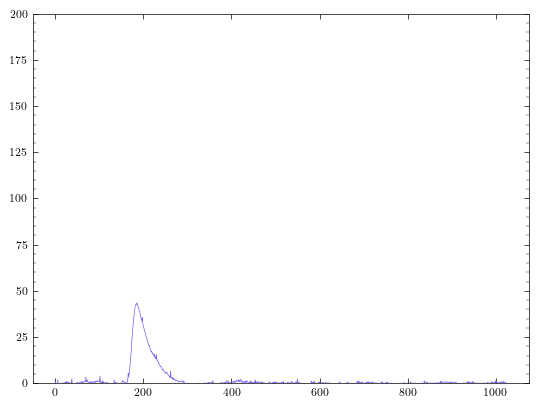

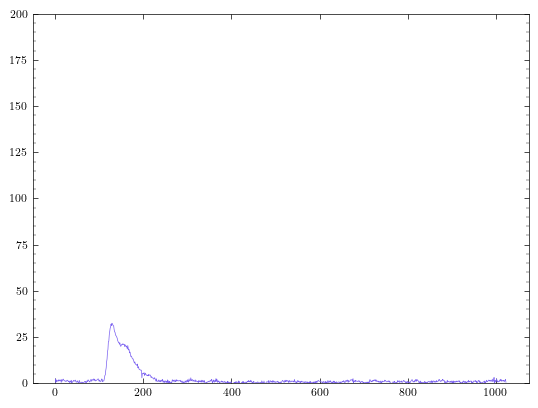

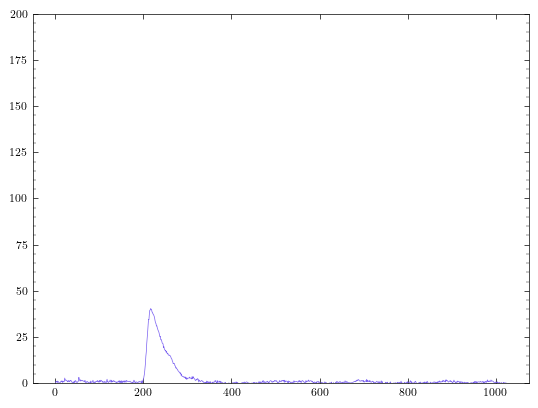

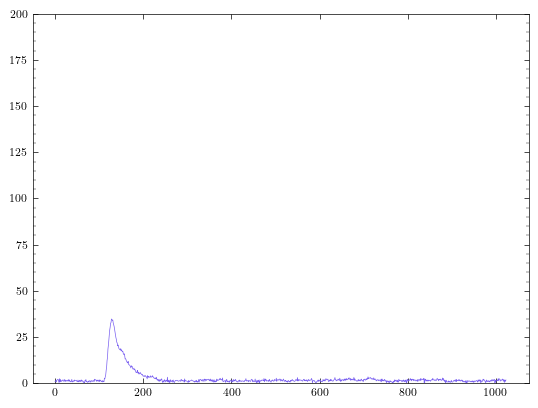

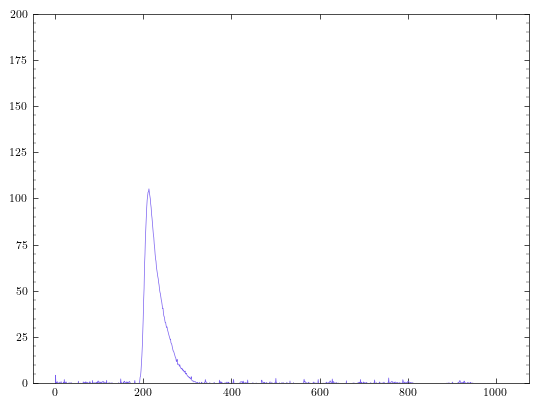

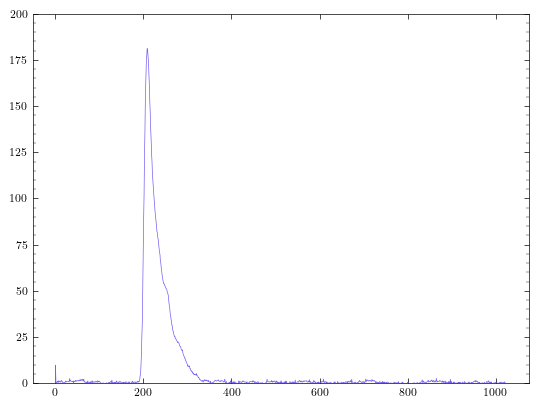

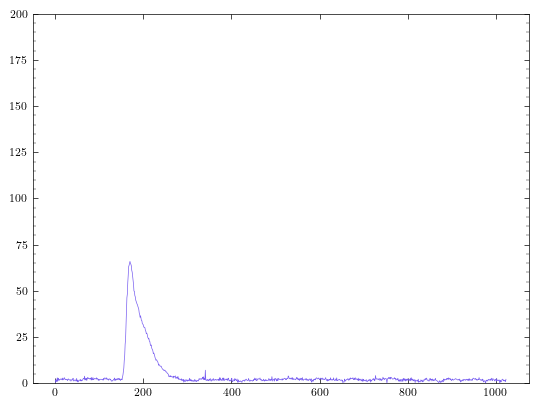

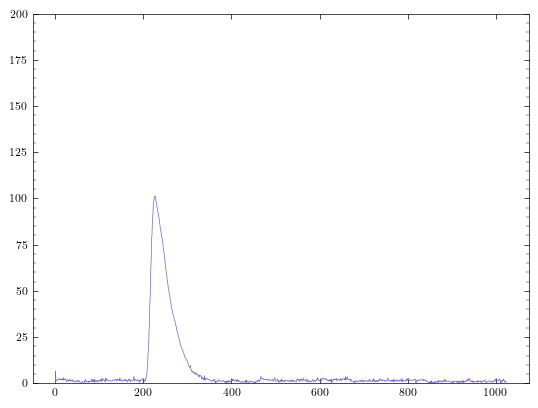

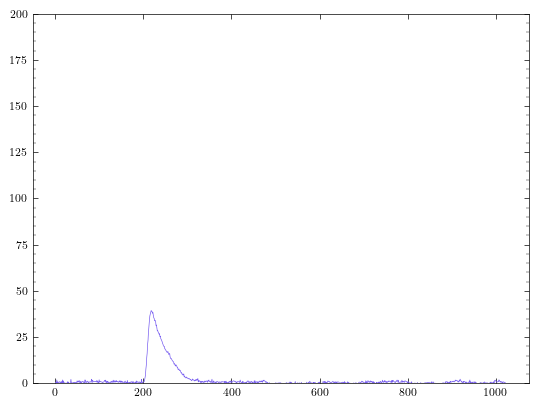

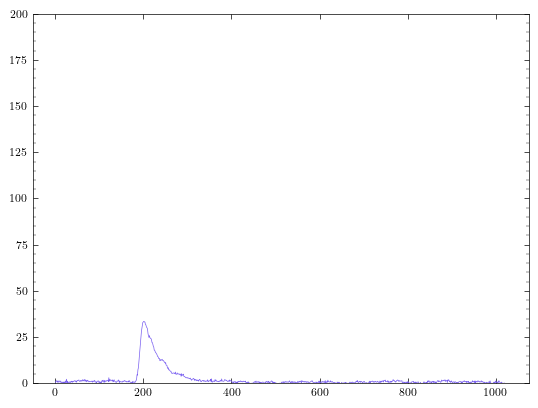

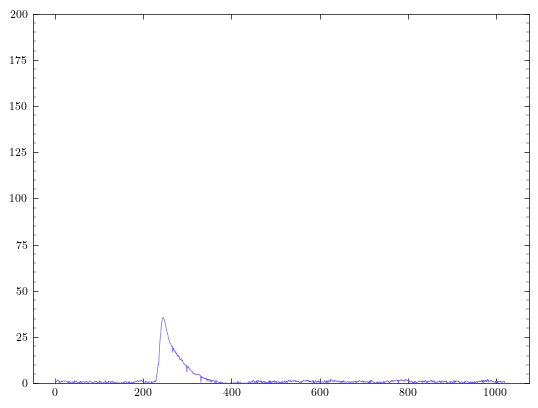

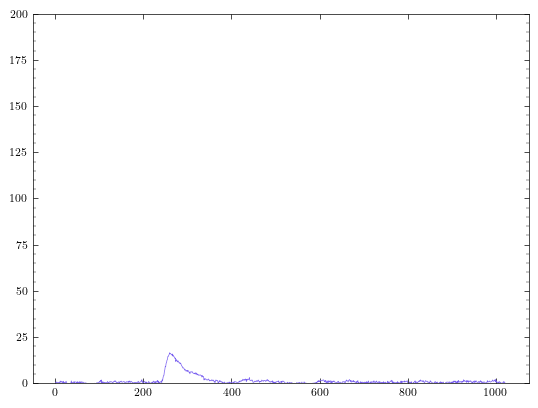

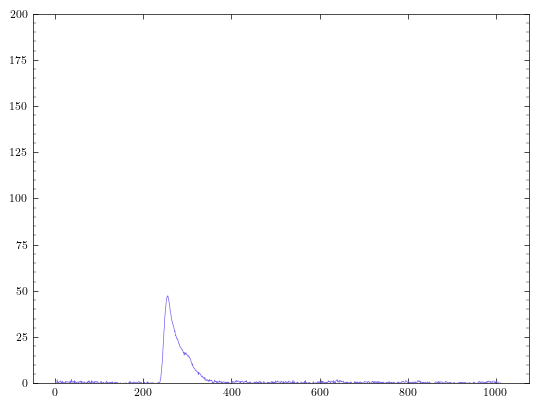

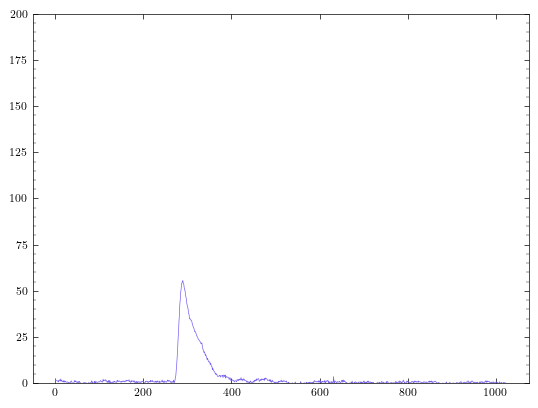

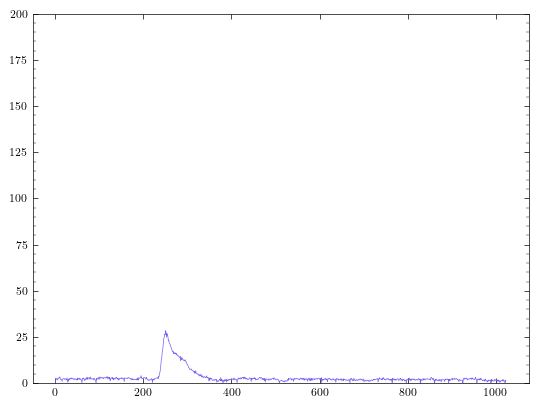

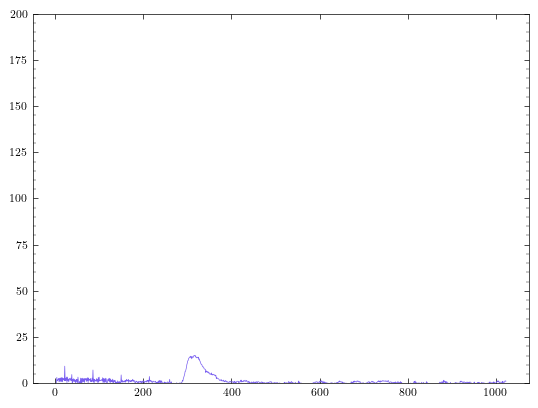

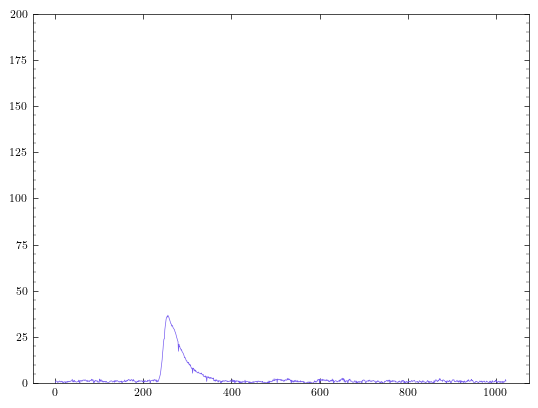

In [312]:
for in range(100):
    plt.plot(waveform_a[x])
    plt.ylim(0, 200)
    plt.show()

In [1]:
fig, (ax_3, ax_6) = plt.subplots(1,2, figsize = (14,7))

x = np.arange(0,len(waveform_a[0]), 1)

for wf, ratio in zip(waveform_a, peak_over_charge_a):
    if ratio < 3.2 and np.all(wf > -200):
        ax_3.plot(x-np.argmax(wf), wf, lw=0.5, alpha=0.25, color = 'navy')
        ax_3.set_title('Waveforms with p/c ratio ~3')
        ax_3.set_xlabel('bins')
        ax_3.set_ylabel('voltage [mV]')
        ax_3.minorticks_on()
    elif ratio > 5.8 and np.all(wf > -200):
        ax_6.plot(x-np.argmax(wf), wf, lw=0.5, alpha=0.25, color = 'navy')
        ax_6.set_title('Waveforms with p/c ratio ~6')
        ax_6.set_xlabel('bins')
        ax_6.set_ylabel('voltage [mV]')
        ax_6.minorticks_on()
plt.savefig('/Users/gracetytus/Downloads/composite_clean.pdf')

NameError: name 'plt' is not defined

In [246]:

mean_wf = np.mean(waveform_a[peak_over_charge_a < 3.2], axis=0)

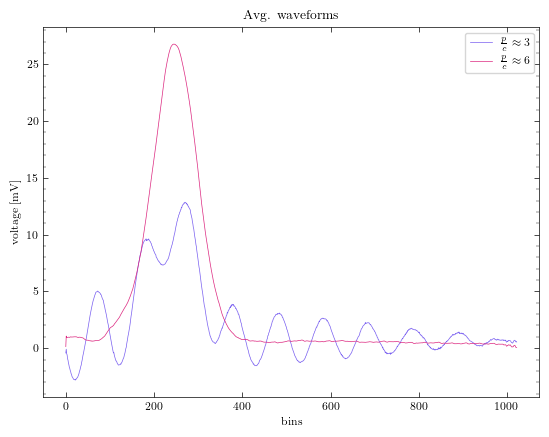

In [274]:
mean_wf = np.mean(waveform_a[peak_over_charge_a < 3.2], axis=0)
plt.plot(mean_wf[1:], label = r'$\frac{p}{c} \approx 3$')
mean_wf = np.mean(waveform_a[peak_over_charge_a > 5.8], axis=0)
plt.plot(mean_wf[1:], label = r'$\frac{p}{c} \approx 6$')
plt.xlabel('bins')
plt.ylabel('voltage [mV]')
plt.legend()
plt.title('Avg. waveforms')
plt.savefig('/Users/gracetytus/Downloads/avgwf.png')

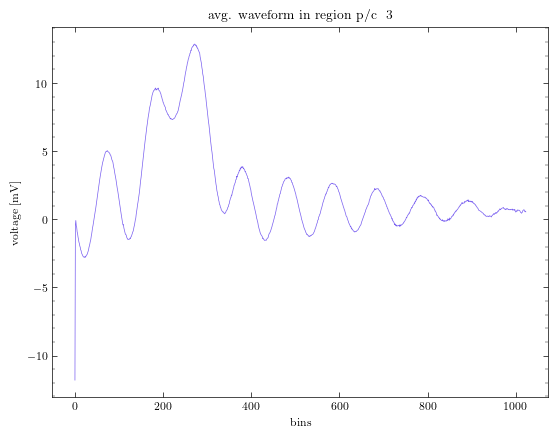

In [248]:
plt.plot(mean_wf)
plt.title('avg. waveform in region p/c ~3')
plt.xlabel('bins')
plt.ylabel('voltage [mV]')
plt.ylim
plt.savefig('/Users/gracetytus/Downloads/avg3.png')

In [249]:
mean_wf = np.mean(waveform_a[peak_over_charge_a > 5.8], axis=0)

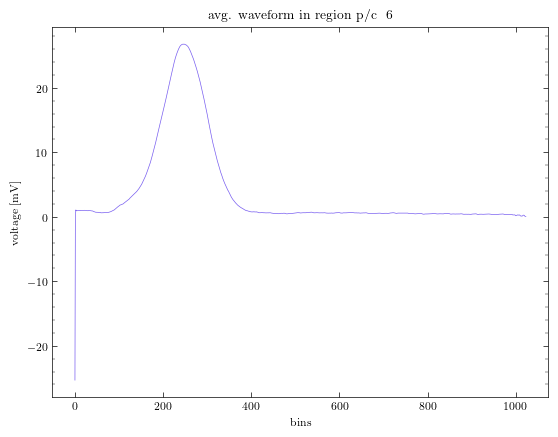

In [250]:
plt.plot(mean_wf)
plt.title('avg. waveform in region p/c ~6')
plt.xlabel('bins')
plt.ylim(0, 30)
plt.ylabel('voltage [mV]')
plt.savefig('/Users/gracetytus/Downloads/avg6.png')

In [204]:
peak_over_charge_a = np.array(peak_over_charge_a)

In [ ]:
(ratio > 2.8 and ratio < 3.2) or (ratio > 4.4 and ratio < 4.6) or (ratio > 5.8 and ratio < 6.2)

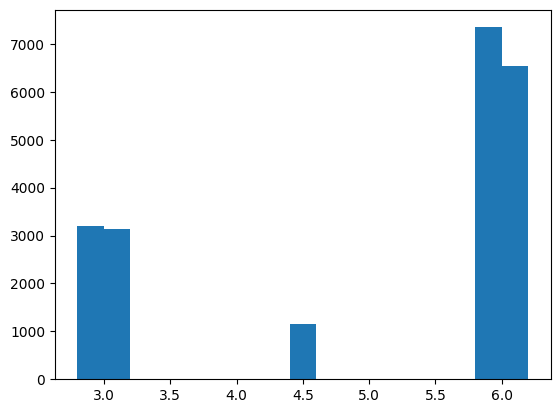

In [216]:
_ = plt.hist(peak_over_charge_a, bins='auto')

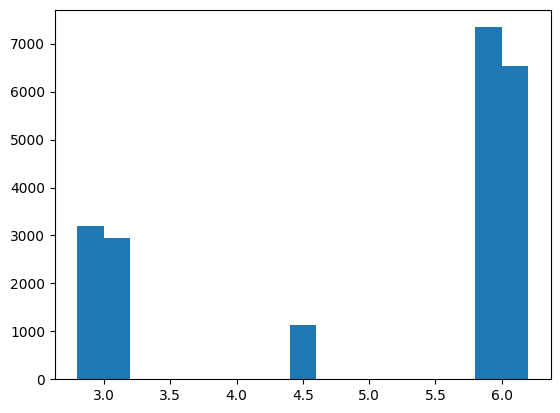

In [220]:
_ = plt.hist(peak_over_charge_a[np.all(waveform_a>-200, axis=1)], bins='auto')

(array([7.5000e+01, 3.2000e+01, 3.0000e+00, 7.0000e+01, 3.1700e+04,
        2.8707e+04, 3.5000e+01, 0.0000e+00, 4.9000e+01, 6.7000e+01]),
 array([-493.359375  , -394.57109375, -295.7828125 , -196.99453125,
         -98.20625   ,    0.58203125,   99.3703125 ,  198.15859375,
         296.946875  ,  395.73515625,  494.5234375 ]),
 <BarContainer object of 10 artists>)

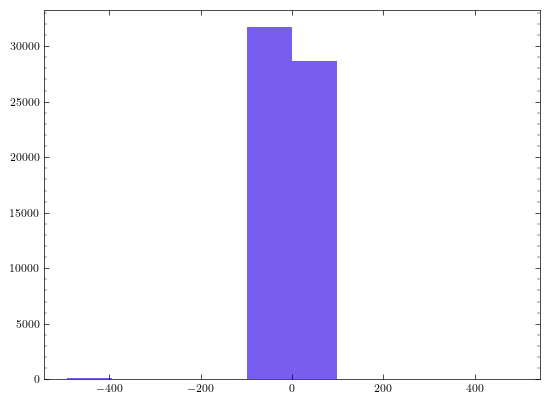

In [281]:
diff = time_a - time_b
plt.hist(diff)

In [ ]:
t_diff = []
ratio = []
for x in range(len(time_a)):
    if q_a[x] == 0: continue
    t = time_a[x] - time_b[x]
    r = v_a[x] / q_a[x] 
    t_diff.append(t)
    ratio.append(r)
    plt.plot(waveform_a[x])
    plt.show()

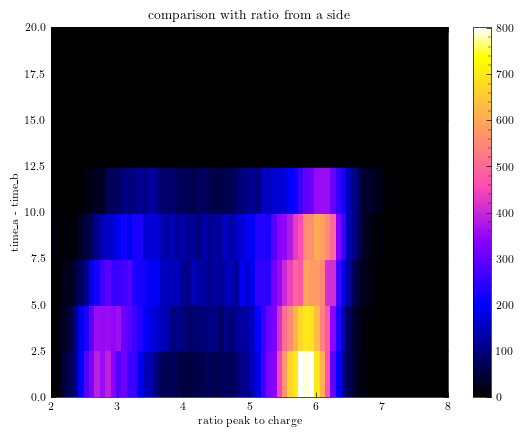

In [305]:
t_diff = np.abs(t_diff)

plt.hist2d(ratio, t_diff, bins = (200, 200), cmap=plt.cm.gnuplot2)
plt.xlabel('ratio peak to charge')
plt.ylabel('time_a - time_b')
plt.title('comparison with ratio from a side')
plt.ylim(0, 20)
plt.xlim(2, 8)
plt.colorbar()
plt.show()
#plt.savefig('/Users/gracetytus/Downloads/2d_sidea.png')

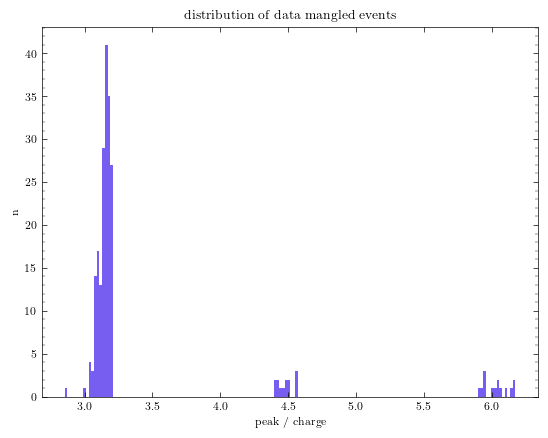

In [252]:
_ = plt.hist(peak_over_charge_a[np.any(waveform_a<-200, axis=1)], bins='auto')
plt.title('distribution of data mangled events')
plt.xlabel('peak / charge')
plt.ylabel('n')
plt.savefig('/Users/gracetytus/Downloads/mangled_dist.png')

In [223]:
len(waveform_a)

21347

In [224]:
waveform_a>-200

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [228]:
np.sum(np.any(waveform_a<-200, axis=1))

np.int64(212)

In [229]:
total = 0
for wf in waveform_a:
    if np.any(wf<-200):
        total += 1

In [230]:
total

212

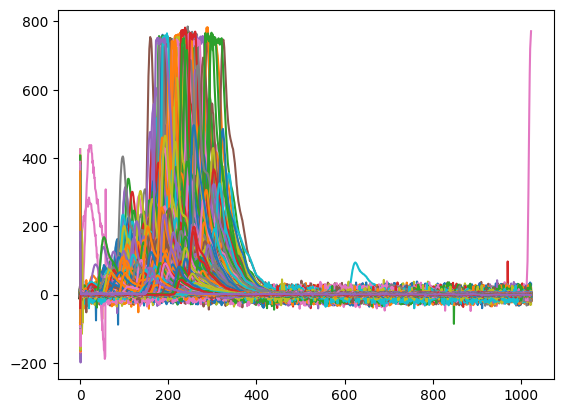

In [231]:
for wf in waveform_a[np.all(waveform_a>-200, axis=1)]:
    plt.plot(wf)

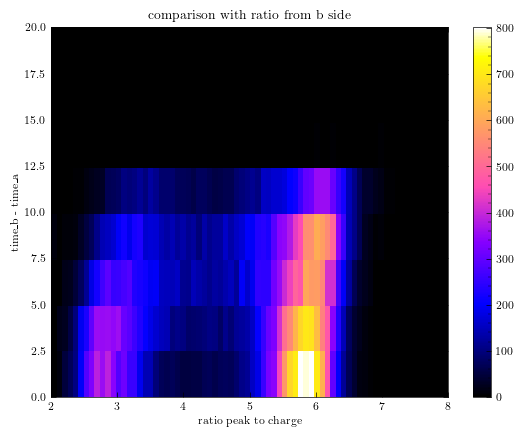

In [314]:
t_diff = []
ratio = []
for x in range(len(time_a)):
    if q_b[x] == 0: continue
    t = time_b[x] - time_a[x]
    r = v_b[x] / q_b[x] 
    t_diff.append(t)
    ratio.append(r)
t_diff = np.abs(t_diff)

plt.hist2d(ratio, t_diff, bins = (200, 200), cmap=plt.cm.gnuplot2)
plt.xlabel('ratio peak to charge')
plt.ylabel('time_b - time_a')
plt.title('comparison with ratio from b side')
plt.ylim(0, 20)
plt.xlim(2, 8)
plt.colorbar()
plt.show()
#plt.savefig('/Users/gracetytus/Downloads/2d_sideb.png')

In [306]:
time_a[0]

np.float64(88.6875)

In [307]:
time_b[0]

np.float64(87.625)

In [308]:
time_a[0] - time_b[0]

np.float64(1.0625)